<a href="https://colab.research.google.com/github/HONG-JU-OH/Bitcoin-Prediction-Project/blob/main/GRU%20%EB%AA%A8%EB%8D%B8%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%B4%20_%202018%EB%85%84%EB%B6%80%ED%84%B0%202022%EB%85%84%20%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8%20%EC%8B%9C%EC%84%B8%EC%97%90%20%EC%98%81%ED%96%A5%EC%9D%84%20%EC%A4%80%EC%82%AC%EA%B1%B4%EB%93%A4%EC%9D%98%20%EB%8C%80%ED%95%9C%20%EB%B3%80%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 2021년 2월 일론머스크 비트코인 투자 언급 전후_ 비트코인 시세 증가요인

### 1.1 데이터 불러오기_ 2018년 1월 1일 부터 2021일 2월 28일의 데이터

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date = "2018-01-01"
end_date = "2022-01-01"
ticker = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data = fdr.DataReader(ticker, start_date, end_date)
df = pd.DataFrame(fdr.DataReader(ticker, start_date, end_date)['Close'])

In [ ]:
df_data = fdr.DataReader(ticker, start_date, end_date)
df_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
df_data.to_csv("musk_bitcoin.csv", index = False)  # df_data을 csv파일로 저장

In [ ]:
len(df_data) # 전체 데이터의 갯수

1155

### 1-2. 데이터 전처리

In [ ]:
# 데이터 전처리
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_data) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler

MinMaxScaler()

In [ ]:
scaled_data

array([[0.18985845, 0.18643403, 0.17962499, 0.18152648, 0.18152648,
        0.01957094],
       [0.18096556, 0.20869944, 0.17900516, 0.20437658, 0.20437658,
        0.0372894 ],
       [0.20432215, 0.21141972, 0.21002621, 0.20862339, 0.20862339,
        0.03742055],
       ...,
       [0.82001738, 0.83669141, 0.80051012, 0.80828527, 0.80828527,
        1.        ],
       [0.80848378, 0.83163999, 0.81618166, 0.80544652, 0.80544652,
        0.12348391],
       [0.80565495, 0.80320949, 0.77683532, 0.78574496, 0.78574496,
        0.14513019]])

### 1-3. train, test 데이터 생성

In [ ]:
# train, test 데이터 생성

train_size = int(len(scaled_data) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x, y = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x), np.array(y)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)

In [ ]:
train_data

array([[0.18985845, 0.18643403, 0.17962499, 0.18152648, 0.18152648,
        0.01957094],
       [0.18096556, 0.20869944, 0.17900516, 0.20437658, 0.20437658,
        0.0372894 ],
       [0.20432215, 0.21141972, 0.21002621, 0.20862339, 0.20862339,
        0.03742055],
       ...,
       [0.12398261, 0.12237467, 0.1269542 , 0.12469068, 0.12469068,
        0.0432763 ],
       [0.12466758, 0.12249434, 0.12820084, 0.12391431, 0.12391431,
        0.03220313],
       [0.12393123, 0.12299936, 0.12815235, 0.12462281, 0.12462281,
        0.03588709]])

In [ ]:
test_data

array([[0.12463975, 0.12272633, 0.12913726, 0.12448079, 0.12448079,
        0.04544343],
       [0.12438498, 0.12302365, 0.1285106 , 0.12464388, 0.12464388,
        0.0472328 ],
       [0.12462025, 0.12214245, 0.12781052, 0.12309479, 0.12309479,
        0.04019567],
       ...,
       [0.82001738, 0.83669141, 0.80051012, 0.80828527, 0.80828527,
        1.        ],
       [0.80848378, 0.83163999, 0.81618166, 0.80544652, 0.80544652,
        0.12348391],
       [0.80565495, 0.80320949, 0.77683532, 0.78574496, 0.78574496,
        0.14513019]])

In [ ]:
x_train

array([[0.18985845, 0.18096556, 0.20432215, ..., 0.12431915, 0.13147461,
        0.1268559 ],
       [0.18096556, 0.20432215, 0.20987575, ..., 0.13147461, 0.1268559 ,
        0.13697064],
       [0.20432215, 0.20987575, 0.2128178 , ..., 0.1268559 , 0.13697064,
        0.13861943],
       ...,
       [0.11699395, 0.11457357, 0.11902911, ..., 0.12474111, 0.12356579,
        0.12640054],
       [0.11457357, 0.11902911, 0.12867002, ..., 0.12356579, 0.12640054,
        0.12398261],
       [0.11902911, 0.12867002, 0.13816808, ..., 0.12640054, 0.12398261,
        0.12466758]])

In [ ]:
 y_train

array([1.36970637e-01, 1.38619428e-01, 1.45736085e-01, 1.46458224e-01,
       1.45397136e-01, 1.30467322e-01, 1.15836273e-01, 1.07353475e-01,
       1.04874133e-01, 9.60353372e-02, 1.09301647e-01, 1.01643628e-01,
       1.02763284e-01, 8.58019918e-02, 8.72340243e-02, 8.73244876e-02,
       7.96279345e-02, 8.78181739e-02, 9.30308649e-02, 9.84620823e-02,
       9.75113919e-02, 9.62208012e-02, 9.96540859e-02, 9.44311026e-02,
       9.23486785e-02, 8.58019251e-02, 7.92661647e-02, 8.03798825e-02,
       6.58920181e-02, 6.07546520e-02, 6.27104225e-02, 5.99934876e-02,
       6.39803450e-02, 6.99151158e-02, 5.96595674e-02, 5.95479521e-02,
       5.71720854e-02, 6.23376596e-02, 6.46481519e-02, 6.00143644e-02,
       6.02463027e-02, 6.24936642e-02, 7.98731846e-02, 7.94962180e-02,
       8.17227027e-02, 8.77624247e-02, 8.28462458e-02, 8.01338817e-02,
       8.36796158e-02, 8.62488368e-02, 9.68088209e-02, 9.81702910e-02,
       9.60299158e-02, 9.98412347e-02, 1.13078702e-01, 9.87770774e-02,
      

In [ ]:
x_test

array([[0.12463975, 0.12438498, 0.12462025, ..., 0.14430689, 0.14006512,
        0.14129978],
       [0.12438498, 0.12462025, 0.12308021, ..., 0.14006512, 0.14129978,
        0.14437575],
       [0.12462025, 0.12308021, 0.12244707, ..., 0.14129978, 0.14437575,
        0.14514691],
       ...,
       [0.42128493, 0.43402826, 0.43753046, ..., 0.94493339, 0.84330249,
        0.85704377],
       [0.43402826, 0.43753046, 0.46260589, ..., 0.84330249, 0.85704377,
        0.82001738],
       [0.43753046, 0.46260589, 0.4639376 , ..., 0.85704377, 0.82001738,
        0.80848378]])

In [ ]:
y_test

array([0.14437575, 0.14514691, 0.14598989, 0.14353572, 0.14936219,
       0.15144353, 0.15358437, 0.15255296, 0.15133588, 0.15448644,
       0.15135685, 0.14210081, 0.14335011, 0.1390057 , 0.14881549,
       0.14839233, 0.14939771, 0.14997907, 0.14740054, 0.15028737,
       0.14860472, 0.14487536, 0.14460405, 0.14412424, 0.14657925,
       0.14725461, 0.14489554, 0.1448613 , 0.14873592, 0.14983307,
       0.1543533 , 0.15619628, 0.16008909, 0.15788042, 0.15751758,
       0.15859377, 0.1545792 , 0.15522436, 0.15786793, 0.16217477,
       0.1653004 , 0.18080884, 0.18447499, 0.1822757 , 0.18559794,
       0.18415182, 0.18589563, 0.1960575 , 0.19016219, 0.19227137,
       0.1956968 , 0.20014228, 0.19931906, 0.19500952, 0.20212733,
       0.20544591, 0.23087309, 0.2301642 , 0.21646257, 0.22852101,
       0.22522883, 0.22378933, 0.23022335, 0.24158369, 0.24062327,
       0.23600606, 0.23375894, 0.24698783, 0.26432239, 0.26759615,
       0.2700278 , 0.28524368, 0.28563279, 0.28053265, 0.28014

### 1-4 모델 생성

In [ ]:
# 모델 생성
model = Sequential()   # 모델의 객체생성
model.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

### 1-5. 모델학습

In [ ]:
# 모델 학습
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
18/18 - 4s - loss: 0.0115 - 4s/epoch - 204ms/step
Epoch 2/100
18/18 - 1s - loss: 0.0019 - 616ms/epoch - 34ms/step
Epoch 3/100
18/18 - 1s - loss: 3.9806e-04 - 915ms/epoch - 51ms/step
Epoch 4/100
18/18 - 1s - loss: 2.0697e-04 - 1s/epoch - 72ms/step
Epoch 5/100
18/18 - 1s - loss: 1.8488e-04 - 1s/epoch - 71ms/step
Epoch 6/100
18/18 - 1s - loss: 1.7031e-04 - 1s/epoch - 77ms/step
Epoch 7/100
18/18 - 1s - loss: 1.6775e-04 - 1s/epoch - 63ms/step
Epoch 8/100
18/18 - 1s - loss: 1.6518e-04 - 1s/epoch - 76ms/step
Epoch 9/100
18/18 - 2s - loss: 1.6240e-04 - 2s/epoch - 94ms/step
Epoch 10/100
18/18 - 1s - loss: 1.6315e-04 - 1s/epoch - 73ms/step
Epoch 11/100
18/18 - 1s - loss: 1.6061e-04 - 1s/epoch - 57ms/step
Epoch 12/100
18/18 - 1s - loss: 1.5966e-04 - 1s/epoch - 67ms/step
Epoch 13/100
18/18 - 1s - loss: 1.5184e-04 - 1s/epoch - 59ms/step
Epoch 14/100
18/18 - 1s - loss: 1.4847e-04 - 925ms/epoch - 51ms/step
Epoch 15/100
18/18 - 1s - loss: 1.4957e-04 - 1s/epoch - 60ms/step
Epoch 16/100
18/1

### 1-6. 예측하기

In [ ]:
# 예측
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

8/8 [==============================] - 0s 9ms/step


### 1-7. 예측결과 시각화

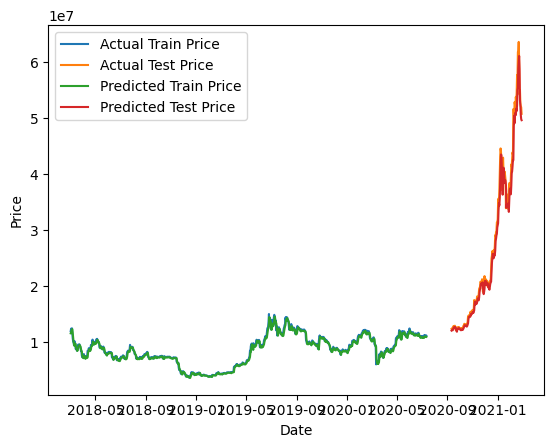

In [ ]:
# 예측 결과 시각화
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.



plt.plot(df[look_back:len(train_data)].index, df[look_back:len(train_data)].values, label='Actual Train Price')
plt.plot(df[len(train_data)+look_back:].index, df[len(train_data)+look_back:].values, label='Actual Test Price')
plt.plot(df[look_back:len(train_data)].index, train_predict, label='Predicted Train Price')
plt.plot(df[len(train_data)+look_back:].index, test_predict, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### 1-8. R2(결정계수)를 통한 모델의 대한 정확도 판단하기

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict = scaler.inverse_transform(train_predict)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])


train_r2_score = r2_score(y_train[0], train_predict[:,0])
test_r2_score = r2_score(y_test[0], test_predict[:,0])


# 결과 출력
print("Train R2 Score : ", train_r2_score)  # 99퍼센트에 정확도를 보여준다
print("Test R2 Score : ", test_r2_score)   # 98% 정확도를 보여준다.

6/6 [==============================] - 0s 7ms/step
Train R2 Score :  0.9790682137176338
Test R2 Score :  0.9838884654153657


### 1-9. 예측값 확인하기

In [ ]:
model.predict([[2022]])  # 2022년을 예측한 값이다

1/1 [==============================] - 0s 108ms/step


array([[5.1868563]], dtype=float32)

In [ ]:
model.predict([[2023]])  # 2023년을 예측한 값이다

1/1 [==============================] - 0s 70ms/step


array([[5.1868563]], dtype=float32)

## 2. 2022년 2월 러시아-우크라이나 전쟁 발발 전후 비트코인 _ 비트코인 시세 변동원인

### 2-1. 데이터불러오기 _ 2018년 1월 1일 부터 2월28일 까지 데이터 불러오기

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date_b = "2018-01-01"
end_date_b = "2022-12-31"
ticker_b = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data_b = fdr.DataReader(ticker_b, start_date_b, end_date_b)
df_b = pd.DataFrame(fdr.DataReader(ticker_b, start_date_b, end_date_b)['Close'])

In [ ]:
df_data_b = fdr.DataReader(ticker_b, start_date_b, end_date_b)
df_data_b.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
len(df_data_b)  # 전체 데이터의 갯수

1520

In [ ]:
df_data_b.to_csv("War_bitcoin.csv", index = False)  # df_data_b을 csv파일로 저장

### 2-2 . 데이터 전처리

In [ ]:
# 데이터 전처리
scaler_b = MinMaxScaler()
scaled_data_b = scaler_b.fit_transform(df_b) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaler_b

MinMaxScaler()

### 2-3 . train, test 데이터 생성

In [ ]:
# train, test 데이터 생성

train_size_b = int(len(scaled_data_b) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data_b = scaled_data_b[:train_size_b]
test_data_b = scaled_data_b[train_size_b:]

def create_dataset_b(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x_b, y_b = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x_b.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y_b.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x_b), np.array(y_b)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train_b, y_train_b = create_dataset_b(train_data_b, look_back)
x_test_b, y_test_b = create_dataset_b(test_data_b, look_back)

In [ ]:
train_data_b

array([[0.14048103],
       [0.15816443],
       [0.16145098],
       ...,
       [0.73795345],
       [0.71836666],
       [0.78589408]])

In [ ]:
test_data_b

array([[0.78701756],
       [0.76974681],
       [0.77998353],
       [0.727814  ],
       [0.78654591],
       [0.76829351],
       [0.77666663],
       [0.7974593 ],
       [0.78925099],
       [0.75774061],
       [0.77188539],
       [0.67123642],
       [0.67575145],
       [0.67801963],
       [0.63264606],
       [0.62820656],
       [0.59137691],
       [0.57752626],
       [0.49300716],
       [0.54651154],
       [0.49574403],
       [0.49912041],
       [0.458855  ],
       [0.51384516],
       [0.50905034],
       [0.51898961],
       [0.50751846],
       [0.46592646],
       [0.45037702],
       [0.4656472 ],
       [0.48660802],
       [0.47745116],
       [0.49147951],
       [0.51763204],
       [0.48162341],
       [0.46237775],
       [0.46682804],
       [0.43367535],
       [0.43563106],
       [0.49132829],
       [0.4797403 ],
       [0.49075999],
       [0.46507952],
       [0.5161755 ],
       [0.5327435 ],
       [0.53547522],
       [0.51347269],
       [0.509

In [ ]:
x_train_b

array([[0.14048103, 0.15816443, 0.16145098, ..., 0.10227909, 0.09835042,
        0.10562754],
       [0.15816443, 0.16145098, 0.16635566, ..., 0.09835042, 0.10562754,
        0.10705619],
       [0.16145098, 0.16635566, 0.19161835, ..., 0.10562754, 0.10705619,
        0.11267147],
       ...,
       [0.6233248 , 0.60807802, 0.65899365, ..., 0.65804855, 0.72685119,
        0.74341744],
       [0.60807802, 0.65899365, 0.65540977, ..., 0.72685119, 0.74341744,
        0.73795345],
       [0.65899365, 0.65540977, 0.68872128, ..., 0.74341744, 0.73795345,
        0.71836666]])

In [ ]:
y_train_b

array([[11958789.        , 12393825.        , 12424052.        , ...,
        60836704.        , 59319244.00000001, 64550840.        ]])

In [ ]:
x_test_b

array([[0.78701756, 0.76974681, 0.77998353, ..., 0.45689372, 0.45495143,
        0.47654535],
       [0.76974681, 0.77998353, 0.727814  , ..., 0.45495143, 0.47654535,
        0.46406044],
       [0.77998353, 0.727814  , 0.78654591, ..., 0.47654535, 0.46406044,
        0.44427828],
       ...,
       [0.68289049, 0.6629012 , 0.67771506, ..., 0.52677993, 0.5494317 ,
        0.55899279],
       [0.6629012 , 0.67771506, 0.66329715, ..., 0.5494317 , 0.55899279,
        0.55735068],
       [0.67771506, 0.66329715, 0.68447968, ..., 0.55899279, 0.55735068,
        0.53585377]])

In [ ]:
y_test_b

array([[39617212.        , 38084616.        , 38329764.        ,
        39202156.        , 39902336.        , 38153268.        ,
        38930592.        , 38646548.00000001, 37719496.        ,
        38709200.00000001, 38391388.00000001, 39212039.99999999,
        37867312.        , 37597472.00000001, 37562160.00000001,
        36265684.        , 35899108.00000001, 36026528.        ,
        36328664.        , 35471076.        , 34233176.        ,
        36914420.00000001, 37189548.        , 38689976.        ,
        39509012.        , 40727676.        , 43033732.        ,
        45493736.        , 46011716.        , 45714020.        ,
        48652396.        , 47950464.        , 46048256.        ,
        45101916.        , 43821776.00000001, 45513668.        ,
        46722796.00000001, 49064284.        , 51067240.        ,
        50189195.99999999, 53176364.        , 52581496.        ,
        52608200.        , 51669976.        , 55554000.        ,
        54744548.        

### 2-4. 모델생성

In [ ]:
# 모델 생성
model_b = Sequential()   # 모델의 객체생성
model_b.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_b.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model_b.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

### 2-5. 모델학습

In [ ]:
# 모델 학습
model_b.fit(x_train_b, y_train_b, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
22/22 - 3s - loss: 0.0177 - 3s/epoch - 147ms/step
Epoch 2/100
22/22 - 1s - loss: 0.0012 - 774ms/epoch - 35ms/step
Epoch 3/100
22/22 - 1s - loss: 5.3173e-04 - 1s/epoch - 51ms/step
Epoch 4/100
22/22 - 1s - loss: 4.0690e-04 - 1s/epoch - 58ms/step
Epoch 5/100
22/22 - 1s - loss: 3.8542e-04 - 932ms/epoch - 42ms/step
Epoch 6/100
22/22 - 1s - loss: 3.7615e-04 - 752ms/epoch - 34ms/step
Epoch 7/100
22/22 - 1s - loss: 3.6326e-04 - 741ms/epoch - 34ms/step
Epoch 8/100
22/22 - 1s - loss: 3.4977e-04 - 749ms/epoch - 34ms/step
Epoch 9/100
22/22 - 1s - loss: 3.4638e-04 - 780ms/epoch - 35ms/step
Epoch 10/100
22/22 - 1s - loss: 3.4315e-04 - 767ms/epoch - 35ms/step
Epoch 11/100
22/22 - 1s - loss: 3.2588e-04 - 747ms/epoch - 34ms/step
Epoch 12/100
22/22 - 1s - loss: 3.1687e-04 - 736ms/epoch - 33ms/step
Epoch 13/100
22/22 - 1s - loss: 3.0936e-04 - 744ms/epoch - 34ms/step
Epoch 14/100
22/22 - 1s - loss: 3.0271e-04 - 755ms/epoch - 34ms/step
Epoch 15/100
22/22 - 1s - loss: 2.9728e-04 - 729ms/epoch - 

### 2-6. 예측해보기

In [ ]:
# 예측
train_predict_b = model_b.predict(x_train_b)
test_predict_b = model_b.predict(x_test_b)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

10/10 [==============================] - 0s 10ms/step


### 2-7. 예측결과 시각화

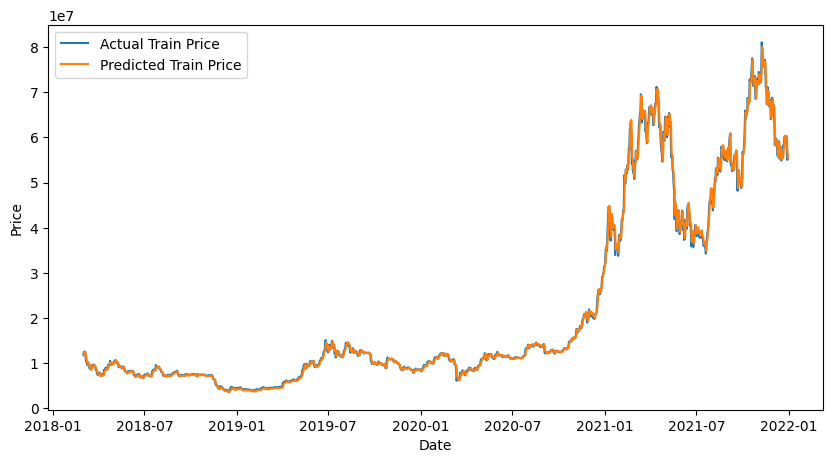

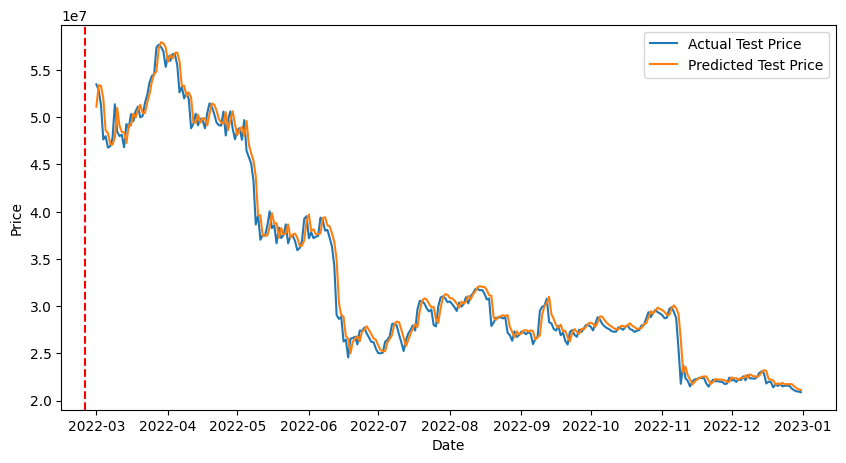

In [ ]:
import matplotlib.pyplot as plt
import datetime

# 예측 결과 시각화
train_predict_b = scaler_b.inverse_transform(train_predict_b)  # inverse_transform()함수로 원본값을 복원할수있다.
y_train_b = scaler_b.inverse_transform(y_train_b.reshape(-1,1))
test_predict_b = scaler_b.inverse_transform(test_predict_b)
y_test_b = scaler_b.inverse_transform(y_test_b.reshape(-1,1))

# train 데이터 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_b[look_back:len(train_data_b)].index, y_train_b, label='Actual Train Price')
plt.plot(df_b[look_back:len(train_data_b)].index, train_predict_b, label='Predicted Train Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# test 데이터 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_b[len(train_data_b)+look_back:].index, y_test_b, label='Actual Test Price')
plt.plot(df_b[len(train_data_b)+look_back:].index, test_predict_b, label='Predicted Test Price')

# 2022년 2월 24일에 빨간색 세로축을 추가합니다.
target_date = datetime.datetime(2022, 2, 24)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### 2-8. R2(결정계수)를 통해 모델의 정확도 판단하기

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_b = model_b.predict(x_train_b)
test_predict_b = model_b.predict(x_test_b)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_b = scaler_b.inverse_transform(train_predict_b)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_b = scaler_b.inverse_transform([y_train_b])
test_predict_b = scaler_b.inverse_transform(test_predict_b)
y_test_b = scaler_b.inverse_transform([y_test_b])


train_r2_score_b = r2_score(y_train_b[0], train_predict_b[:,0])
test_r2_score_b = r2_score(y_test_b[0], test_predict_b[:,0])


# 결과 출력
print("Train R2 Score : ", train_r2_score_b)  # 99퍼센트에 정확도를 보여준다
print("Test R2 Score : ", test_r2_score_b)   # 96% 정확도를 보여준다.

8/8 [==============================] - 0s 15ms/step
Train R2 Score :  0.9960717521566689
Test R2 Score :  0.9573195235719385


### 2-9. 예측값 확인하기

In [ ]:
model_b.predict([[2022]])  # 2022년을 예측한 값이다

1/1 [==============================] - 0s 452ms/step


array([[6.0464764]], dtype=float32)

In [ ]:
model_b.predict([[2023]])  # 2023년을 예측한 값이다

1/1 [==============================] - 0s 44ms/step


array([[6.0464764]], dtype=float32)

## 3. 일론머스크 테슬라 비트코인 거래 관련 발언(2021/ 05 / 13) -> 이후 폭락

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date_c = "2018-01-01"
end_date_c = "2021-12-31"
ticker_c = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data_c = fdr.DataReader(ticker_c, start_date_c, end_date_c)
df_c = pd.DataFrame(fdr.DataReader(ticker_c, start_date_c, end_date_c)['Close'])

In [ ]:
len(df_data_c)

1461

In [ ]:
df_data_c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1217 entries, 2018-01-01 to 2021-05-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1217 non-null   float64
 1   High       1217 non-null   float64
 2   Low        1217 non-null   float64
 3   Close      1217 non-null   float64
 4   Adj Close  1217 non-null   float64
 5   Volume     1217 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 66.6 KB


In [ ]:
df_data_c = fdr.DataReader(ticker_c, start_date_c, end_date_c)
df_data_c.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
# 데이터 전처리
scaler_c = MinMaxScaler()
scaled_data_c = scaler_c.fit_transform(df_c) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
# train, test 데이터 생성

train_size_c = int(len(scaled_data_c) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data_c = scaled_data_c[:train_size_c]
test_data_c = scaled_data_c[train_size_c:]

def create_dataset_c(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x_c, y_c = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x_c.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y_c.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x_c), np.array(y_c)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train_c, y_train_c = create_dataset_c(train_data_c, look_back)
x_test_c, y_test_c = create_dataset_c(test_data_c, look_back)

In [ ]:
# 모델 생성
model_c = Sequential()   # 모델의 객체생성
model_c.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_c.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model_c.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
# 모델 학습
model_c.fit(x_train_c, y_train_c, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
18/18 - 1s - loss: 257848646828032.0000 - 751ms/epoch - 42ms/step
Epoch 2/100
18/18 - 1s - loss: 257848613273600.0000 - 588ms/epoch - 33ms/step
Epoch 3/100
18/18 - 1s - loss: 257848596496384.0000 - 610ms/epoch - 34ms/step
Epoch 4/100
18/18 - 1s - loss: 257848579719168.0000 - 576ms/epoch - 32ms/step
Epoch 5/100
18/18 - 1s - loss: 257848546164736.0000 - 591ms/epoch - 33ms/step
Epoch 6/100
18/18 - 1s - loss: 257848546164736.0000 - 595ms/epoch - 33ms/step
Epoch 7/100
18/18 - 1s - loss: 257848479055872.0000 - 691ms/epoch - 38ms/step
Epoch 8/100
18/18 - 1s - loss: 257848462278656.0000 - 977ms/epoch - 54ms/step
Epoch 9/100
18/18 - 1s - loss: 257848445501440.0000 - 995ms/epoch - 55ms/step
Epoch 10/100
18/18 - 1s - loss: 257848428724224.0000 - 750ms/epoch - 42ms/step
Epoch 11/100
18/18 - 1s - loss: 257848395169792.0000 - 576ms/epoch - 32ms/step
Epoch 12/100
18/18 - 1s - loss: 257848344838144.0000 - 589ms/epoch - 33ms/step
Epoch 13/100
18/18 - 1s - loss: 257848344838144.0000 - 588ms/

In [ ]:
# 예측
train_predict_c = model_c.predict(x_train_c)
test_predict_c = model_c.predict(x_test_c)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

8/8 [==============================] - 0s 8ms/step


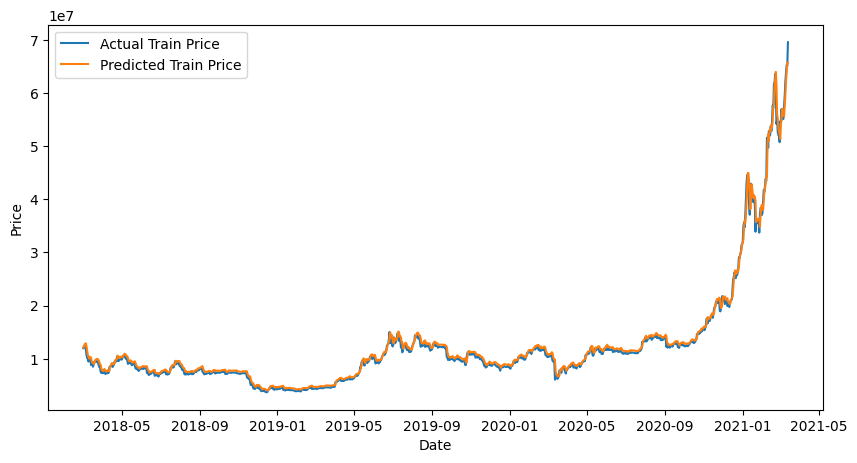

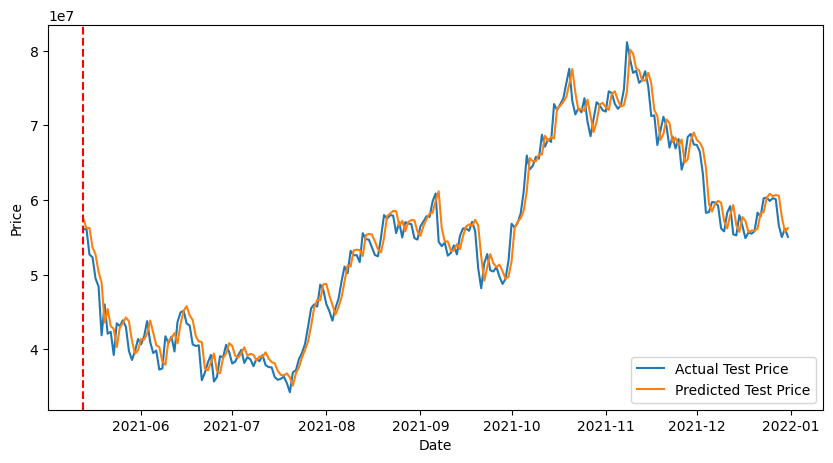

In [ ]:
import matplotlib.pyplot as plt
import datetime

# 예측 결과 시각화
train_predict_c = scaler_c.inverse_transform(train_predict_c)  # inverse_transform()함수로 원본값을 복원할수있다.
y_train_c = scaler_c.inverse_transform(y_train_c.reshape(-1,1))
test_predict_c = scaler_c.inverse_transform(test_predict_c)
y_test_c = scaler_c.inverse_transform(y_test_c.reshape(-1,1))

# train 데이터 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_c[look_back:len(train_data_c)].index, y_train_c, label='Actual Train Price')
plt.plot(df_c[look_back:len(train_data_c)].index, train_predict_c, label='Predicted Train Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# test 데이터 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_c[len(train_data_c)+look_back:].index, y_test_c, label='Actual Test Price')
plt.plot(df_c[len(train_data_c)+look_back:].index, test_predict_c, label='Predicted Test Price')

# 2021년 5월 13일에 빨간색 세로축을 추가합니다.
target_date = datetime.datetime(2021, 5, 13)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Train 데이터의 결정 계수 계산
train_r2_score_c = r2_score(y_train_c, train_predict_c)

# Test 데이터의 결정 계수 계산
test_r2_score_c = r2_score(y_test_c, test_predict_c)

# 결과 출력
print("Train R2 Score:", train_r2_score_c)
print("Test R2 Score:", test_r2_score_c)

Train R2 Score: 0.9941037886742988
Test R2 Score: -20.037566560562926


## 4. 러시아-우크라이나 전쟁 (2022/02/24)

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 8.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



# 데이터 불러오기
start_date_d = "2018-01-01"
end_date_d = "2022-12-31"
ticker_d = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data_d = fdr.DataReader(ticker_d, start_date_d, end_date_d)
df_d = pd.DataFrame(fdr.DataReader(ticker_d, start_date_d, end_date_d)['Close'])

In [ ]:
df_data_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1248 entries, 2018-01-01 to 2021-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1248 non-null   float64
 1   High       1248 non-null   float64
 2   Low        1248 non-null   float64
 3   Close      1248 non-null   float64
 4   Adj Close  1248 non-null   float64
 5   Volume     1248 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.2 KB


In [ ]:
len(df_data_d)

1248

In [ ]:
df_data_d = fdr.DataReader(ticker_d, start_date_d, end_date_d)
df_data_d.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,14548333.0,10962700800000
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,15918331.0,17899344238000
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,16172952.0,17950689456200
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,16552935.0,23115024576400
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,18510128.0,25319034814500


In [ ]:
df_d.head()

,Close
Date,
2018-01-01,14548333.0
2018-01-02,15918331.0
2018-01-03,16172952.0
2018-01-04,16552935.0
2018-01-05,18510128.0


In [ ]:
# 데이터 전처리
scaler_d = MinMaxScaler()
scaled_data_d = scaler_d.fit_transform(df_d) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
# train, test 데이터 생성

train_size_d = int(len(scaled_data_d) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data_d = scaled_data_d[:train_size_d]
test_data_d = scaled_data_d[train_size_d:]

def create_dataset_d(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x_d, y_d = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x_d.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y_d.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x_d), np.array(y_d)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train_d, y_train_d = create_dataset_d(train_data_d, look_back)
x_test_d, y_test_d = create_dataset_d(test_data_d, look_back)

In [ ]:
# 모델 생성
model_d = Sequential()   # 모델의 객체생성
model_d.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_d.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model_d.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
# 모델 학습
model_d.fit(x_train_d, y_train_d, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다
# 에포크가 높을수록 손실함수의 결과값이 줄어든다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
22/22 - 3s - loss: 0.0231 - 3s/epoch - 147ms/step
Epoch 2/100
22/22 - 1s - loss: 0.0017 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 5.4957e-04 - 1s/epoch - 55ms/step
Epoch 4/100
22/22 - 1s - loss: 4.4207e-04 - 865ms/epoch - 39ms/step
Epoch 5/100
22/22 - 1s - loss: 4.1536e-04 - 730ms/epoch - 33ms/step
Epoch 6/100
22/22 - 1s - loss: 4.0639e-04 - 723ms/epoch - 33ms/step
Epoch 7/100
22/22 - 1s - loss: 3.9297e-04 - 738ms/epoch - 34ms/step
Epoch 8/100
22/22 - 1s - loss: 3.7141e-04 - 720ms/epoch - 33ms/step
Epoch 9/100
22/22 - 1s - loss: 3.7026e-04 - 721ms/epoch - 33ms/step
Epoch 10/100
22/22 - 1s - loss: 3.5494e-04 - 702ms/epoch - 32ms/step
Epoch 11/100
22/22 - 1s - loss: 3.3883e-04 - 721ms/epoch - 33ms/step
Epoch 12/100
22/22 - 1s - loss: 3.3830e-04 - 708ms/epoch - 32ms/step
Epoch 13/100
22/22 - 1s - loss: 3.4050e-04 - 695ms/epoch - 32ms/step
Epoch 14/100
22/22 - 1s - loss: 3.2097e-04 - 723ms/epoch - 33ms/step
Epoch 15/100
22/22 - 1s - loss: 3.1661e-04 - 753ms/epoch - 

In [ ]:
# 예측
train_predict_d = model_d.predict(x_train_d)
test_predict_d = model_d.predict(x_test_d)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

10/10 [==============================] - 0s 9ms/step


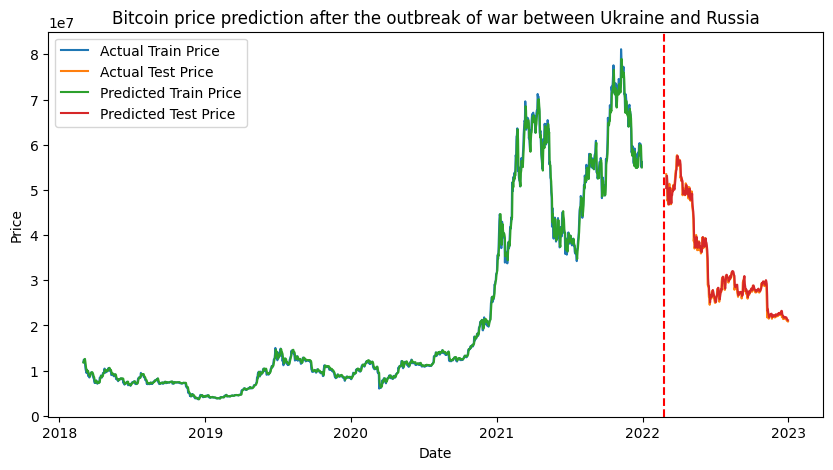

In [ ]:
# 예측 결과 시각화
train_predict_d = scaler_d.inverse_transform(train_predict_d)
test_predict_d = scaler_d.inverse_transform(test_predict_d)


# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2022년 2월 24일에 빨간색 세로축을 추가합니다.
target_date = datetime.datetime(2022, 2, 24)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_d[look_back:len(train_data_d)].index, df_d[look_back:len(train_data_d)].values, label='Actual Train Price')
plt.plot(df_d[len(train_data_d)+look_back:].index, df_d[len(train_data_d)+look_back:].values, label='Actual Test Price')
plt.plot(df_d[look_back:len(train_data_d)].index, train_predict_d, label='Predicted Train Price')
plt.plot(df_d[len(train_data_d)+look_back:].index, test_predict_d, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price prediction after the outbreak of war between Ukraine and Russia')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_d = model_d.predict(x_train_d)
test_predict_d = model_d.predict(x_test_d)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_d = scaler_d.inverse_transform(train_predict_d)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_d = scaler_d.inverse_transform([y_train_d])
test_predict_d = scaler_d.inverse_transform(test_predict_d)
y_test_d = scaler_d.inverse_transform([y_test_d])


train_r2_score_d= r2_score(y_train_d[0], train_predict_d[:,0])
test_r2_score_d = r2_score(y_test_d[0], test_predict_d[:,0])


# 결과 출력
print("Train R2 Score : ", train_r2_score_d)  # 99퍼센트에 정확도를 보여준다
print("Test R2 Score : ", test_r2_score_d)   # 95% 정확도를 보여준다.

8/8 [==============================] - 0s 15ms/step
Train R2 Score :  0.9962525126317751
Test R2 Score :  0.9496889547665454


## 5. 일론머스크 (2021년 5월 13일)

In [ ]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 데이터 불러오기
start_date_q = "2018-01-01"
end_date_q = "2021-12-31"
ticker_q = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df_data_q = fdr.DataReader(ticker_q, start_date_q, end_date_q)
df_q = pd.DataFrame(fdr.DataReader(ticker_q, start_date_q, end_date_q)['Close'])

In [ ]:
# 데이터 전처리
scaler_q = MinMaxScaler()
scaled_data_q = scaler_q.fit_transform(df_q) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
# train, test 데이터 생성

train_size_q = int(len(scaled_data_q) * 0.8)   ## 전체 데이터셋 중 80%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data_q = scaled_data_q[:train_size_q]
test_data_q = scaled_data_q[train_size_q:]

def create_dataset_q(data, look_back=60): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x_q, y_q = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):
        x_q.append(data[i:(i+look_back), 0])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다.
        y_q.append(data[i+look_back, 0])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x_q), np.array(y_q)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train_q, y_train_q = create_dataset_q(train_data_q, look_back)
x_test_q, y_test_q = create_dataset_q(test_data_q, look_back)

In [ ]:
train_data_q

array([[0.16107988],
       [0.18135622],
       [0.18512468],
       ...,
       [0.12832622],
       [0.12786626],
       [0.12994369]])

In [ ]:
test_data_q

array([[0.13061199],
       [0.12858786],
       [0.1285325 ],
       [0.13176871],
       [0.13304047],
       [0.13696572],
       [0.13845304],
       [0.14216286],
       [0.14003682],
       [0.13981774],
       [0.14059651],
       [0.13716141],
       [0.13776964],
       [0.13988184],
       [0.143834  ],
       [0.14672852],
       [0.16080297],
       [0.16359084],
       [0.16173403],
       [0.1646822 ],
       [0.1633987 ],
       [0.16494641],
       [0.17396232],
       [0.16873151],
       [0.17060324],
       [0.17364206],
       [0.17758637],
       [0.17685731],
       [0.1730331 ],
       [0.17934447],
       [0.1822915 ],
       [0.20485371],
       [0.20422277],
       [0.19206626],
       [0.20276441],
       [0.19984337],
       [0.19856667],
       [0.20427593],
       [0.21435293],
       [0.21350239],
       [0.20940583],
       [0.20741232],
       [0.21964767],
       [0.23453251],
       [0.23743594],
       [0.23959112],
       [0.25309098],
       [0.253

In [ ]:
# 모델 생성
model_q = Sequential()   # 모델의 객체생성
model_q.add(GRU(50, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.

model_q.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model_q.compile(loss='mean_squared_error', optimizer='adam')  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.

# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.


In [ ]:
model_q

In [ ]:
# 모델 학습
model_q.fit(x_train_q, y_train_q, epochs=100, batch_size=64, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100
18/18 - 3s - loss: 0.0225 - 3s/epoch - 169ms/step
Epoch 2/100
18/18 - 1s - loss: 0.0065 - 587ms/epoch - 33ms/step
Epoch 3/100
18/18 - 1s - loss: 7.7437e-04 - 588ms/epoch - 33ms/step
Epoch 4/100
18/18 - 1s - loss: 3.3695e-04 - 598ms/epoch - 33ms/step
Epoch 5/100
18/18 - 1s - loss: 2.4270e-04 - 595ms/epoch - 33ms/step
Epoch 6/100
18/18 - 1s - loss: 2.4453e-04 - 590ms/epoch - 33ms/step
Epoch 7/100
18/18 - 1s - loss: 2.3233e-04 - 772ms/epoch - 43ms/step
Epoch 8/100
18/18 - 1s - loss: 2.0807e-04 - 957ms/epoch - 53ms/step
Epoch 9/100
18/18 - 1s - loss: 2.0986e-04 - 963ms/epoch - 54ms/step
Epoch 10/100
18/18 - 1s - loss: 2.1074e-04 - 743ms/epoch - 41ms/step
Epoch 11/100
18/18 - 1s - loss: 1.9970e-04 - 590ms/epoch - 33ms/step
Epoch 12/100
18/18 - 1s - loss: 2.1355e-04 - 606ms/epoch - 34ms/step
Epoch 13/100
18/18 - 1s - loss: 1.9752e-04 - 603ms/epoch - 33ms/step
Epoch 14/100
18/18 - 1s - loss: 1.9016e-04 - 572ms/epoch - 32ms/step
Epoch 15/100
18/18 - 1s - loss: 2.1136e-04 - 568ms/ep

In [ ]:
# 예측
train_predict_q = model_q.predict(x_train_q)
test_predict_q = model_q.predict(x_test_q)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

8/8 [==============================] - 0s 8ms/step


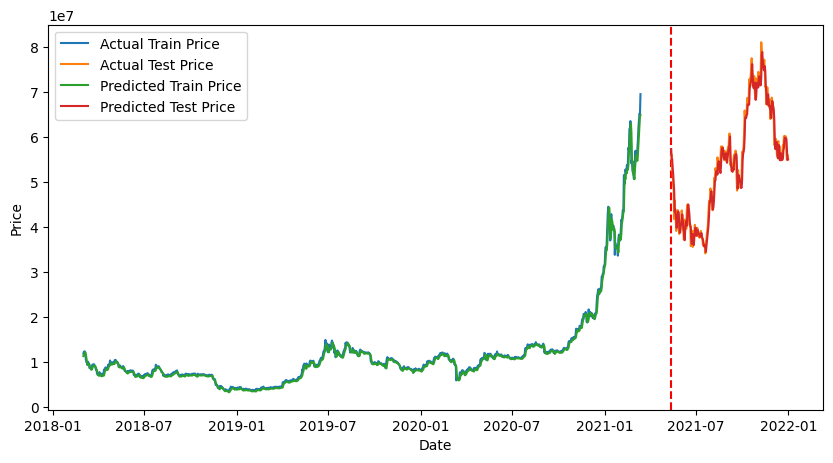

In [ ]:
# 예측 결과 시각화
train_predict_q = scaler_q.inverse_transform(train_predict_q)
test_predict_q = scaler_q.inverse_transform(test_predict_q)


# train_predict와 test_predict 배열에 NaN 값이 포함되어 있는지 확인하기 위해  np.isnan() 함수를 사용
# 만약 NaN 값이 있다면, 이를 np.ma.array() 함수를 사용하여 NaN 값을 마스킹한 배열을 생성한다.
# np.ma.array()에서는 평균값을 구할수있다.(조건이 참일때 평균값을 구해서 NaN값으로 대체한다)

# train_predict와 test_predict 배열의 값을 scaler.inverse_transform() 함수를 사용하여 스케일링된 값을 원래의 값으로 복원합니다.

plt.figure(figsize=(10, 5))

# 2021년 5월 13일에 빨간색 세로축을 추가합니다.
target_date = datetime.datetime(2021, 5, 13)
plt.axvline(x=target_date, color='red', linestyle='--')

plt.plot(df_q[look_back:len(train_data_q)].index, df_q[look_back:len(train_data_q)].values, label='Actual Train Price')
plt.plot(df_q[len(train_data_q)+look_back:].index, df_q[len(train_data_q)+look_back:].values, label='Actual Test Price')
plt.plot(df_q[look_back:len(train_data_q)].index, train_predict_q, label='Predicted Train Price')
plt.plot(df_q[len(train_data_q)+look_back:].index, test_predict_q, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# train 및 test 데이터에 대한 예측값 생성
train_predict_q = model_d.predict(x_train_q)
test_predict_q = model_d.predict(x_test_q)

# 스케일링 된 값을 다시 원래 값으로 변환
train_predict_q = scaler_q.inverse_transform(train_predict_q)  #inverse_transform() 함수를 이용해 원본값으로 복원가능하다
y_train_q = scaler_q.inverse_transform([y_train_q])
test_predict_q = scaler_q.inverse_transform(test_predict_q)
y_test_q = scaler_q.inverse_transform([y_test_q])


train_r2_score_q= r2_score(y_train_q[0], train_predict_q[:,0])
test_r2_score_q = r2_score(y_test_q[0], test_predict_q[:,0])


# 결과 출력
print("Train R2 Score : ", train_r2_score_q)  # 98퍼센트에 정확도를 보여준다
print("Test R2 Score : ", test_r2_score_q)   # 98% 정확도를 보여준다.

6/6 [==============================] - 0s 13ms/step
Train R2 Score :  0.9817228179070517
Test R2 Score :  0.9804779182445463
